In [1]:
%matplotlib inline
%load_ext lab_black

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_error as MAE,
    mean_squared_error as RMSE,
    r2_score as R2,
)
from model import (
    load_data,
    train_and_test,
    hyperparam_graph,
    hyperparam_plot,
    make_grid,
    eval_model,
    tv_split_path,
    test_split_path,
    PickleableKerasRegressor,
    HistoryKerasRegressor,
    reload_model,
    compute_metrics,
    dnn_gen,
    plot_net_training_curves,
)
from lstm import (
    WindowRegressor,
    WindowGenerator,
    compile_and_fit,
    lstm_gen,
    lstm_dense_gen,
    prepare_splits,
)
from plot import (
    pred_plot,
    err_plot,
)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from shared import process_multi_site

resources = "resources/"
metadata_path = os.path.join(resources, "fdk_site_info.csv")
data_path = os.path.join(resources, "data.csv.gz")
predictions_path = os.path.join(resources, "predictions.csv.gz")
results_path = os.path.join(resources, "results.csv")

Deploy Streamlit apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


# LSTM

## Data preparation

Loading the data
Loading metadata and joining
Adding GPP and GPP_diff
Dropping unused features
Removing bad values
Adding engineered features
Remove unused features
NA: 839
Interpolating


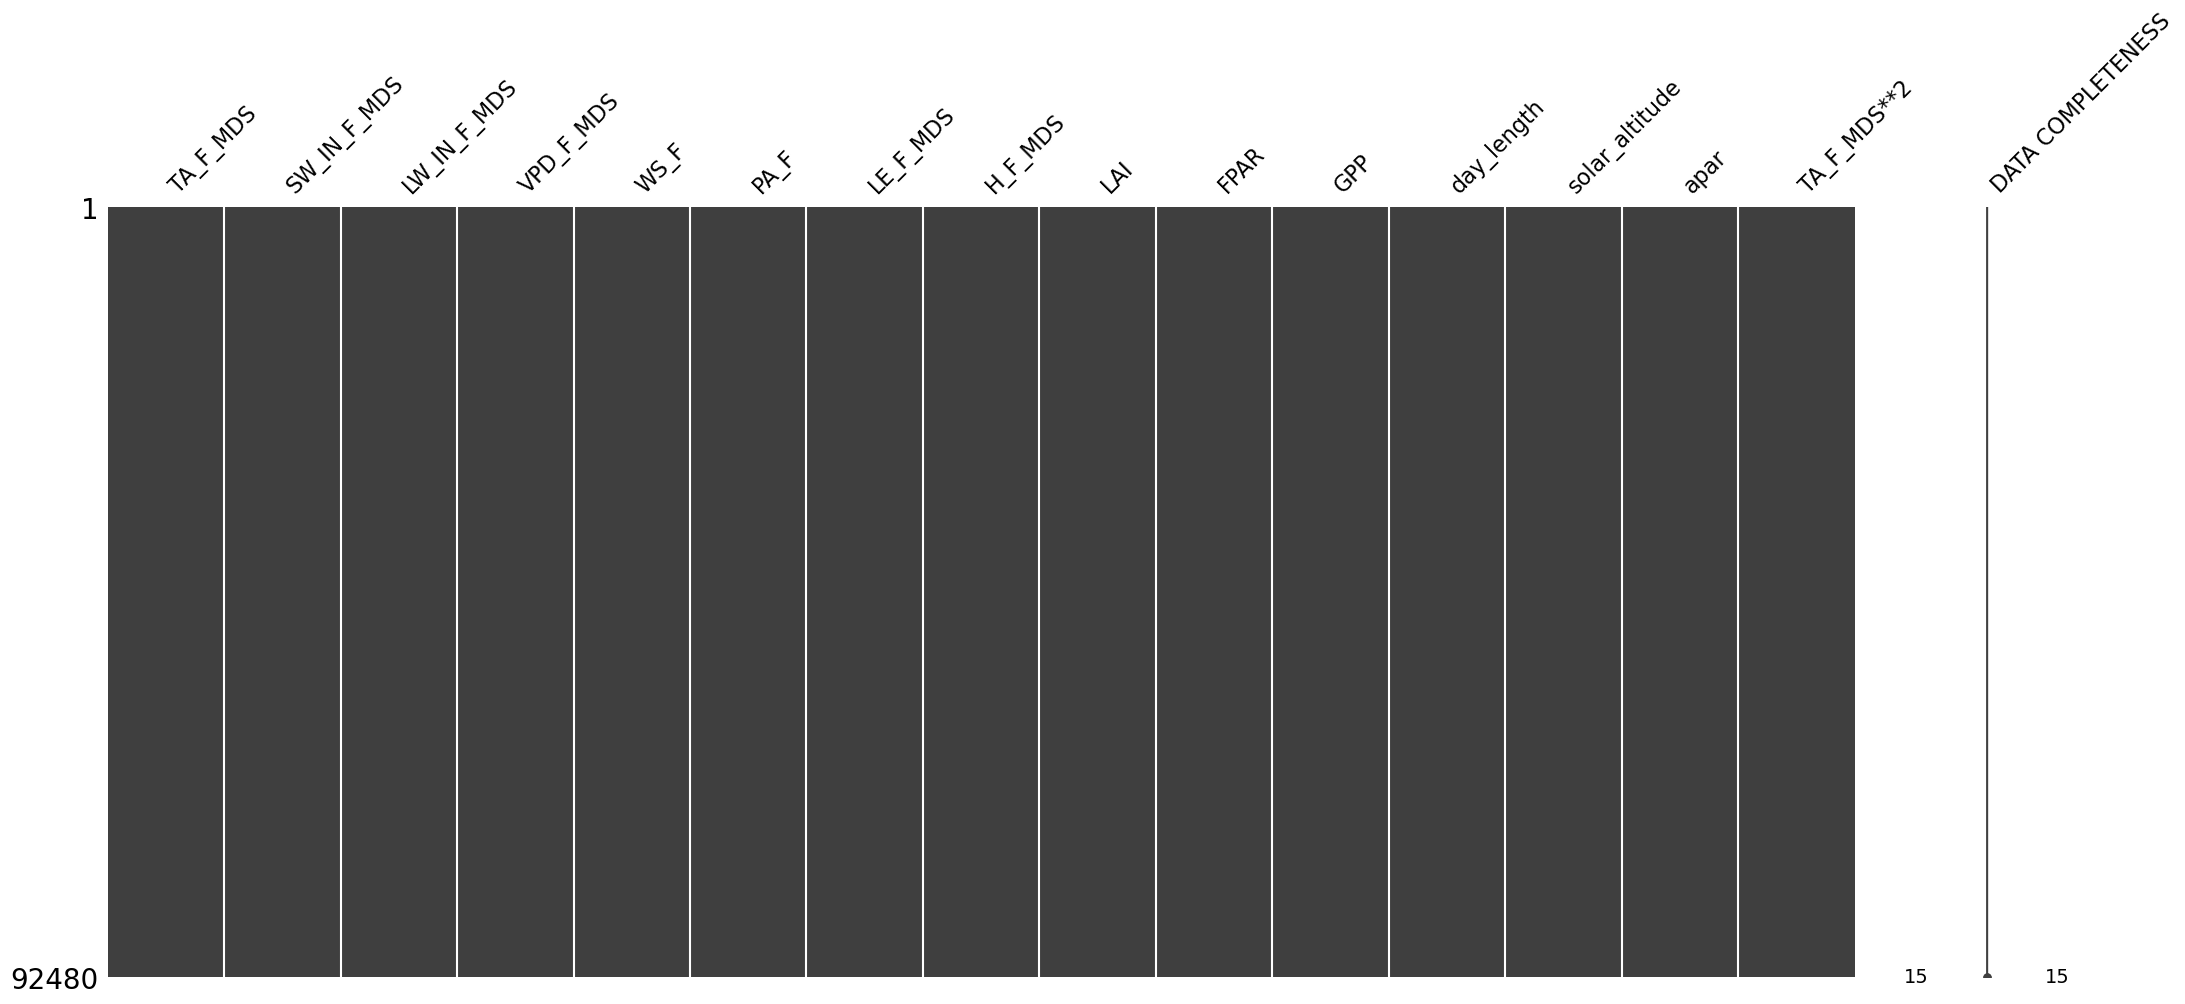

In [2]:
MAX_WINDOW = 64
df = process_multi_site(
    data_path, metadata_path, qc_threshold=0.5, show_na=True, window_size=MAX_WINDOW
)

In [3]:
X_tv, y_tv, X_test, y_test = prepare_splits(df, MAX_WINDOW)

## Simple LSTM

In [4]:
def build_model(model_fun, pickeable=False):
    if pickeable:
        reg = PickleableKerasRegressor(
            model_fun,
            verbose=1,
            shuffle=False,
            epochs=100,
        )
    else:
        reg = HistoryKerasRegressor(
            model_fun,
            verbose=0,
            shuffle=False,
            epochs=100,
            callbacks=[keras.callbacks.EarlyStopping(patience=4, mode="min")],
        )
    regressor = WindowRegressor(
        reg,
        max_window=MAX_WINDOW,
    )
    return regressor

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END regressor__reg__batch_size=8, regressor__reg__regressor__epochs=100, regressor__reg__regressor__kernel_regularizer=0.001, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=6, regressor__reg__regressor__recurrent_regularizer=0.001, regressor__reg__regressor__verbose=False, regressor__reg__shuffle=True, regressor__reg__window_size=8, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time= 3.2min
[CV] END regressor__reg__batch_size=8, regressor__reg__regressor__epochs=100, regressor__reg__regressor__kernel_regularizer=0.001, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=6, regressor__reg__regressor__recurrent_regularizer=0.001, regressor__reg__regressor__verbose=False, regressor__reg__shuffle=True, regressor__reg__window_size=16, regressor__scaler=QuantileTrans

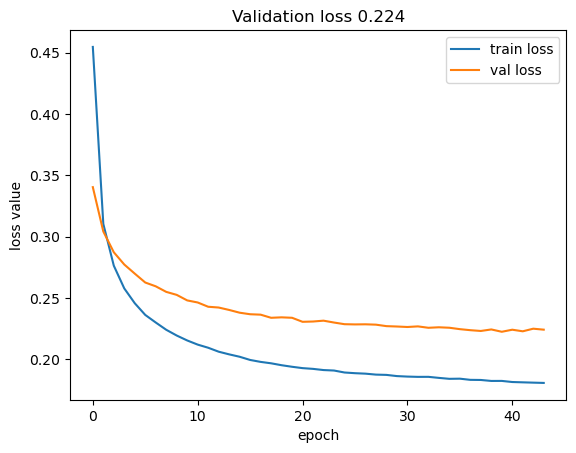

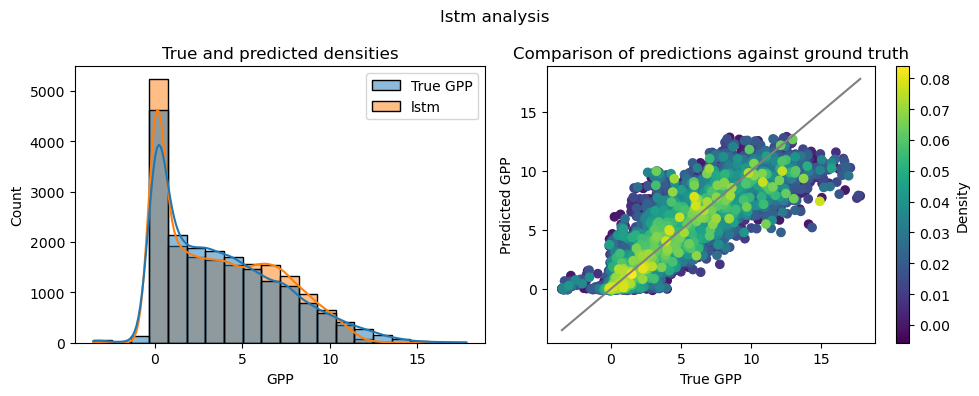

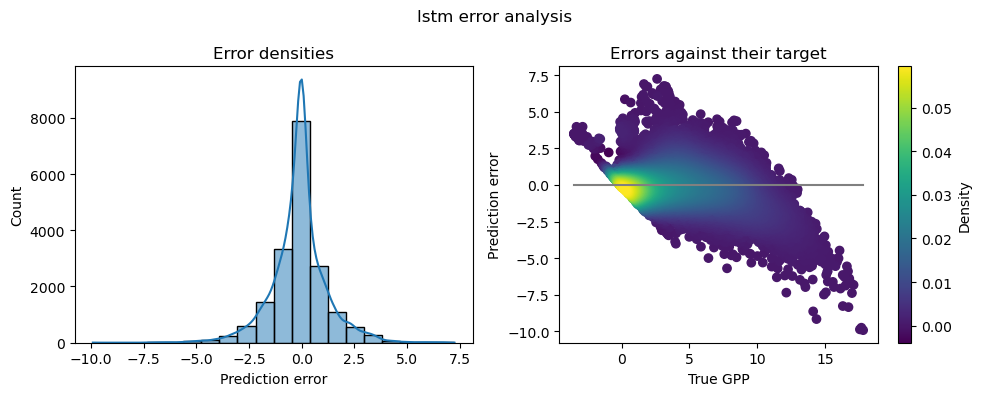

In [28]:
name = "lstm"

grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__window_size": [MAX_WINDOW],
        "reg__window_size": [8, 16, 32],  # Total window size
        "reg__shuffle": [True],
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [6, 8, 10],
        "reg__regressor__epochs": [100],
        "reg__regressor__verbose": [False],
        "reg__regressor__recurrent_regularizer": [0.001],
        "reg__regressor__kernel_regularizer": [0.001],
        "reg__batch_size": [8],
    },
)
df_pred = pd.DataFrame()
df_pred["True GPP"] = y_test.copy()
df_pred["baseline"] = df_pred["True GPP"]
model, df_pred[name], _, _, _, _ = eval_model(
    None,
    build_model(lstm_gen),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
plot_net_training_curves(
    model.best_estimator_.regressor_.named_steps.reg.regressor.history
)
pred_plot(df_pred, name)
err_plot(df_pred, name)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Epoch 1/30
924/924 [==============================] - 8s 7ms/step - loss: 0.3701 - mean_absolute_error: 0.4324 - val_loss: 0.2846 - val_mean_absolute_error: 0.3673
Epoch 2/30
924/924 [==============================] - 6s 6ms/step - loss: 0.2441 - mean_absolute_error: 0.3475 - val_loss: 0.2580 - val_mean_absolute_error: 0.3444
Epoch 3/30
924/924 [==============================] - 6s 6ms/step - loss: 0.2221 - mean_absolute_error: 0.3287 - val_loss: 0.2453 - val_mean_absolute_error: 0.3329
Epoch 4/30
924/924 [==============================] - 6s 7ms/step - loss: 0.2111 - mean_absolute_error: 0.3196 - val_loss: 0.2394 - val_mean_absolute_error: 0.3281
Epoch 5/30
924/924 [==============================] - 6s 6ms/step - loss: 0.2051 - mean_absolute_error: 0.3145 - val_loss: 0.2360 - val_mean_absolute_error: 0.3242
Epoch 6/30
924/924 [==============================] - 6s 6ms/step - loss: 0.2009 - mean_absolute_error: 0.3112 - val_loss

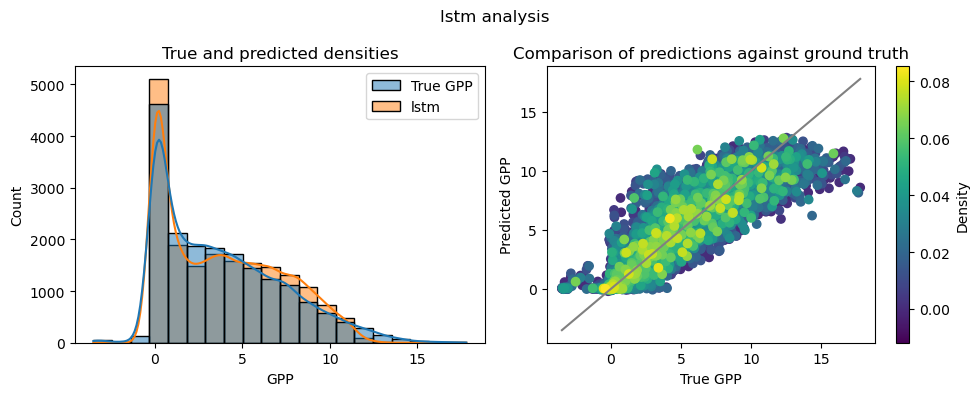

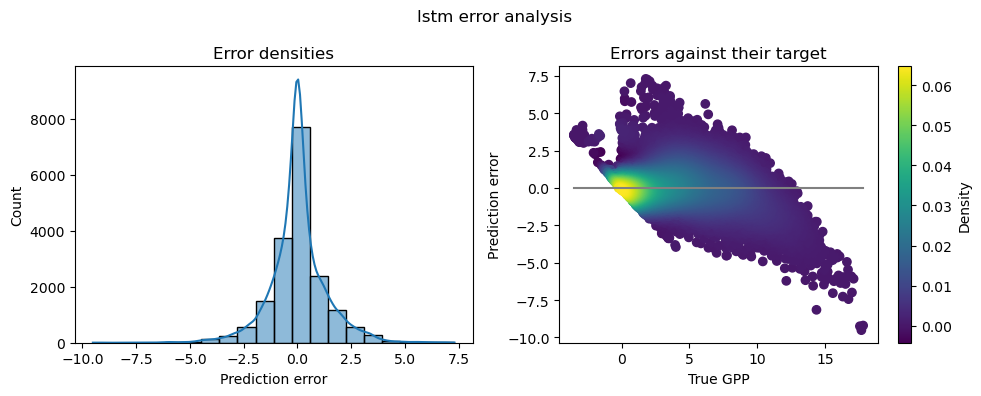

In [26]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__window_size": [MAX_WINDOW],
        "reg__window_size": [16],  # Total window size
        "reg__shuffle": [True],
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [6],
        "reg__regressor__epochs": [30],
        "reg__regressor__verbose": [True],
        "reg__regressor__recurrent_regularizer": [0.001],
        "reg__regressor__kernel_regularizer": [0.001],
        "reg__batch_size": [4],
    },
)
df_pred = pd.DataFrame()
df_pred["True GPP"] = y_test.copy()
df_pred["baseline"] = df_pred["True GPP"]
model, df_pred[name], _, _, _, _ = eval_model(
    name,
    build_model(lstm_gen, True),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
pred_plot(df_pred, name)
err_plot(df_pred, name)

## LSTM + Dense

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] END regressor__reg__batch_size=1, regressor__reg__regressor__dense_units=64, regressor__reg__regressor__epochs=60, regressor__reg__regressor__kernel_regularizer=0.001, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=16, regressor__reg__regressor__recurrent_regularizer=0.001, regressor__reg__regressor__verbose=0, regressor__reg__window_size=64, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time= 8.1min
Total training time: 909.81s
Mean fit time: 480.66s
----
Predicting train...
Prediction time: 3.65s
Score (train): 0.85
MAE (train): 0.88
RMSE (train): 1.71
----
Predicting test...
Prediction time: 0.92s
Score (test): 0.84
MAE (test): 0.88
RMSE (test): 1.77


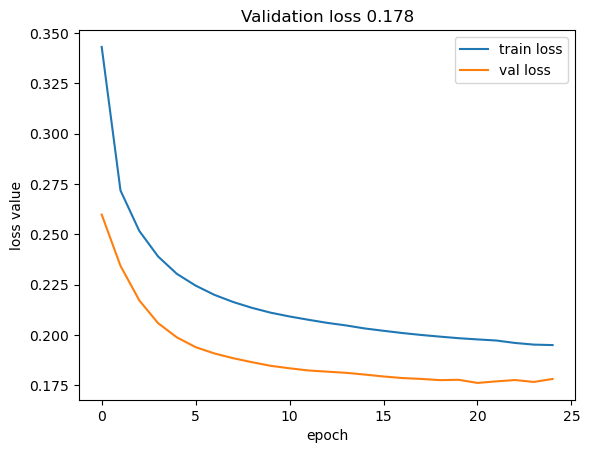

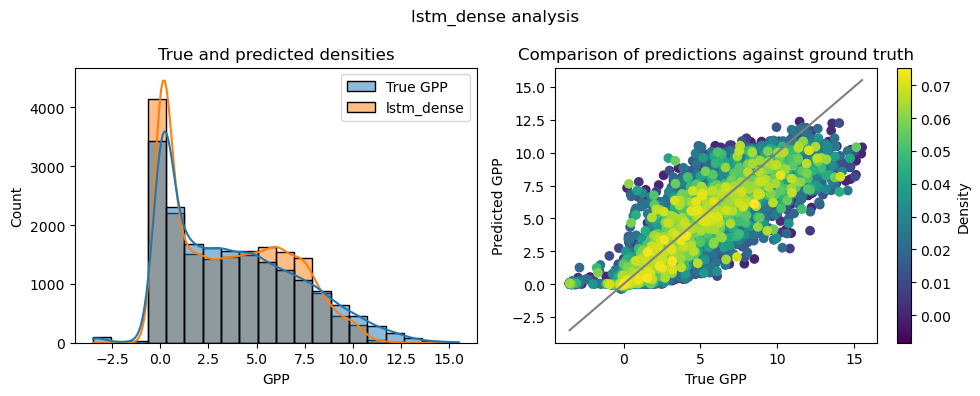

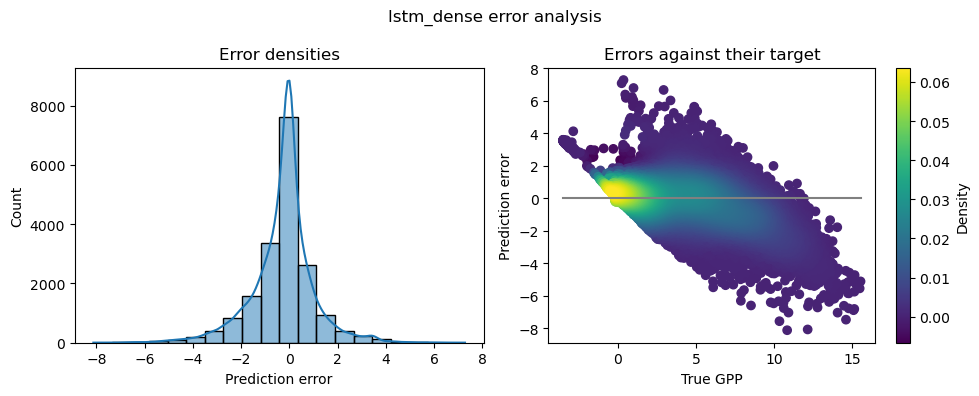

In [5]:
name = "lstm_dense"

grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__window_size": [MAX_WINDOW],
        "reg__window_size": [MAX_WINDOW],
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [16],
        "reg__regressor__dense_units": [64],
        "reg__regressor__recurrent_regularizer": [0.001],
        "reg__regressor__kernel_regularizer": [0.001],
        "reg__regressor__epochs": [60],
        "reg__regressor__verbose": [0],
        "reg__batch_size": [1],
    },
)
df_pred = pd.DataFrame()
df_pred["True GPP"] = y_test.copy()
df_pred["baseline"] = df_pred["True GPP"]
model, df_pred[name], _, _, _, _ = eval_model(
    None,
    build_model(lstm_dense_gen),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
plot_net_training_curves(
    model.best_estimator_.regressor_.named_steps.reg.regressor.history
)
pred_plot(df_pred, name)
err_plot(df_pred, name)

In [6]:
name = "lstm_dense"

grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__window_size": [MAX_WINDOW],
        "reg__window_size": [MAX_WINDOW],
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [16],
        "reg__regressor__dense_units": [64],
        "reg__regressor__recurrent_regularizer": [0.001],
        "reg__regressor__kernel_regularizer": [0.001],
        "reg__regressor__epochs": [60],
        "reg__regressor__verbose": [1],
        "reg__batch_size": [1],
    },
)
df_pred = pd.DataFrame()
df_pred["True GPP"] = y_test.copy()
df_pred["baseline"] = df_pred["True GPP"]
model, df_pred[name], _, _, _, _ = eval_model(
    name,
    build_model(lstm_dense_gen, True),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
#plot_net_training_curves(
#    model.best_estimator_.regressor_.named_steps.reg.regressor.history
#)
pred_plot(df_pred, name)
err_plot(df_pred, name)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Epoch 1/60
924/924 [==============================] - 20s 20ms/step - loss: 0.3531 - mean_absolute_error: 0.3928 - val_loss: 0.2523 - val_mean_absolute_error: 0.3378
Epoch 2/60
924/924 [==============================] - 20s 22ms/step - loss: 0.2680 - mean_absolute_error: 0.3350 - val_loss: 0.2309 - val_mean_absolute_error: 0.3233
Epoch 3/60
924/924 [==============================] - 18s 20ms/step - loss: 0.2472 - mean_absolute_error: 0.3208 - val_loss: 0.2169 - val_mean_absolute_error: 0.3133
Epoch 4/60
924/924 [==============================] - 17s 19ms/step - loss: 0.2349 - mean_absolute_error: 0.3133 - val_loss: 0.2074 - val_mean_absolute_error: 0.3067
Epoch 5/60
924/924 [==============================] - 18s 19ms/step - loss: 0.2268 - mean_absolute_error: 0.3086 - val_loss: 0.2010 - val_mean_absolute_error: 0.3023
Epoch 6/60
924/924 [==============================] - 18s 20ms/step - loss: 0.2209 - mean_absolute_error: 0.305

AttributeError: 'PickleableKerasRegressor' object has no attribute 'history'

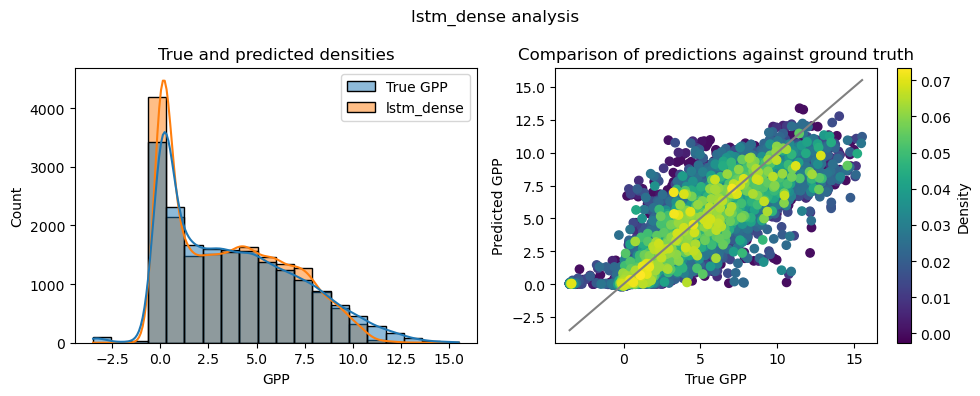

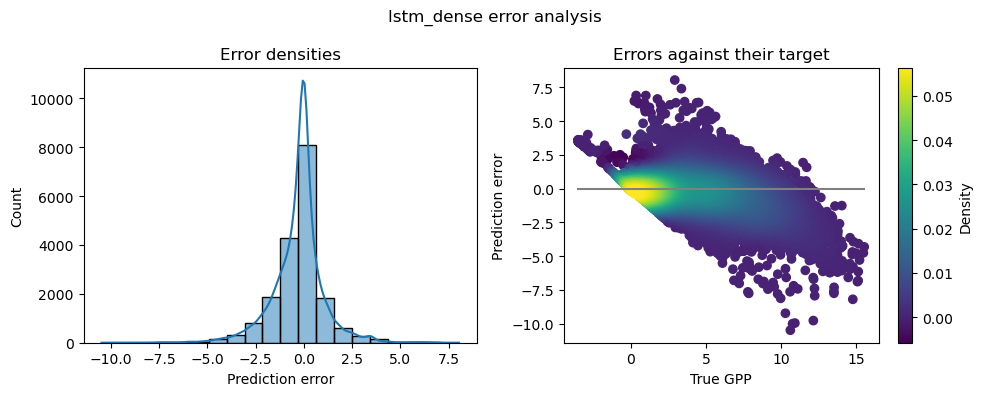

In [7]:
pred_plot(df_pred, name)
err_plot(df_pred, name)

## Saving results

In [9]:
results = []

for model_name in ["lstm", "lstm_dense"]:
    print(f"Predicting {model_name}...")
    model = reload_model(model_name)
    _, pred_time_train, r2_train, mae_train, rmse_train = compute_metrics(
        model, X_tv, y_tv, "train", verbose=False
    )
    y_pred_test, pred_time_test, r2_test, mae_test, rmse_test = compute_metrics(
        model, X_test, y_test, "test", verbose=False
    )
    res = {
        "model": model_name,
        "pred_time_train": pred_time_train,
        "R2_train": r2_train,
        "MAE_train": mae_train,
        "RMSE_train": rmse_train,
        "pred_time_test": pred_time_test,
        "R2_test": r2_test,
        "MAE_test": mae_test,
        "RMSE_test": rmse_test,
    }
    results.append(res)

results_df = (
    pd.DataFrame(results)
    # .drop_duplicates(subset=["model"], keep="last")
    .set_index("model")
)
other_results = pd.read_csv(results_path).set_index("model")
results_df = pd.concat([other_results, results_df])
results_df.to_csv(results_path)
results_df

Predicting lstm...
1156/1156 [==============================] - 2s 2ms/step
Predicting lstm_dense...
289/289 [==============================] - 1s 3ms/step


,pred_time_train,R2_train,MAE_train,RMSE_train,pred_time_test,R2_test,MAE_test,RMSE_test
model,,,,,,,,
baseline,0.00,0.00,2.85,11.63,0.00,-0.00,2.84,11.66
ridge_2p_rs,0.06,0.61,1.52,4.58,0.03,0.60,1.54,4.68
knn_2p_pca,3.91,0.66,1.37,3.93,1.64,0.65,1.39,4.04
ridge_full,0.56,0.80,1.05,2.36,0.27,0.79,1.07,2.41
rf_full,1.58,0.87,0.82,1.52,0.69,0.86,0.86,1.67
svr_full,533.83,0.88,0.80,1.43,233.05,0.87,0.81,1.50
dnn_full,10.60,0.89,0.75,1.26,4.52,0.89,0.77,1.34
lstm,8.33,0.85,0.90,1.78,2.41,0.85,0.89,1.74
lstm_dense,4.16,0.86,0.86,1.61,1.07,0.84,0.89,1.84
